In [3]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Conv2DTranspose
from keras.layers.activation import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
print(tf.__version__)

In [ ]:
training_data = np.load('../datasets/full_numpy_bitmap_smiley face.npy')
# training_data = np.array([np.array_split(img_arr, 28) for img_arr in training_data])
training_data = training_data.reshape(training_data.shape[0], 28, 28).astype(
    "float32")
X_train = training_data
print(X_train[0].shape)
plt.imshow(X_train[0])

In [ ]:
#Define input image dimensions
#Large images take too much time and resources.
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
print(img_shape)
noise_shape = (100,) #1D array of size 100 (latent vector / noise)
print(noise_shape)

In [ ]:
def build_generator():

    generator = Sequential()
    generator.add(Dense(256 * 7 * 7, input_shape=(100,)))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((7, 7, 256)))
    generator.add(Conv2DTranspose(128, kernel_size=5, strides=1, padding="same"))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(64, kernel_size=3, strides=2,padding="same"))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation='tanh'))
    generator.summary()
    noise = Input(shape=(100,))
    fake_image = generator(noise)
    return Model(inputs=noise, outputs=fake_image)

def build_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(128, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.2))
    discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.2))
    discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.2))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.summary()
    img = Input(shape=(28, 28, 1))
    probability = discriminator(img)
    return Model(inputs=img, outputs=probability)

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("gen_images/epoch_%d.png" % epoch)
    plt.close()

def train(epochs, batch_size=128, save_interval=100):
    training_data = np.load('../datasets/full_numpy_bitmap_smiley face.npy')
    # training_data = np.array([np.array_split(img_arr, 28) for img_arr in training_data])
    training_data = training_data.reshape(training_data.shape[0], 28, 28)
    X_train = training_data
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3) 
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
        noise = np.random.normal(0, 1, (batch_size, 100)) 
        valid_y = np.array([1] * batch_size)
        g_loss = combined.train_on_batch(noise, valid_y)     
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        if epoch % save_interval == 0:
            save_imgs(epoch)


optimizer = Adam(0.001, 0.5)
disc_optimizer = RMSprop(0.005)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
z = Input(shape=(100,))
img = generator(z)     
discriminator.trainable = False  
valid = discriminator(img) 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
train(epochs=10000, batch_size=32, save_interval=50)

In [ ]:
combined.save('saved_models/smiley_gan_h5_v1', save_format='h5')

In [6]:
loaded_combined = load_model('saved_models/smiley_gan_h5')
loaded_generator = loaded_combined.get_layer('model_128')

1/1 [==============================] - 0s 18ms/step


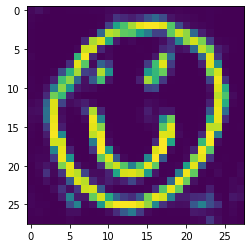

In [31]:
noise = np.random.normal(0, 1, (1, 100))
gen_imgs = loaded_generator.predict(noise)
plt.imshow(gen_imgs[0])